In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Num GPUs Available:  1
Mon Mar  1 22:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Hub version: ", hub.__version__)

Tensorflow Version:  2.4.1
Hub version:  0.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_data_images = "/content/Plant_leave_diseases_dataset_without_augmentation"
if not os.path.exists(path_data_images):
  !unzip "/content/drive/My Drive/Plant_leaf_diseases_dataset_without_augmentation.zip"


Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/i

In [ ]:
import time
import os
from os.path import exists

def totalImagesCount(directory):
    count = 0
    for sub_dir in os.walk(directory):
        for file in sub_dir[2]:
            count += 1
    return count
print('Total no of images in the data set are:', totalImagesCount(path_data_images))

Total no of images in the data set are: 55448


In [ ]:
INPUT_SHAPE = (224, 224)
BATCH_NUMBER = 64 
dataAugmented =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split=0.2,
                                                          shear_range=0.2,
                                                          zoom_range=0.2,
                                                          horizontal_flip=True,
                                                          rotation_range=90,
                                                          width_shift_range=0.2, 
                                                          height_shift_range=0.2,
                                                          fill_mode='nearest'
                                                          )

validation_generator = dataAugmented.flow_from_directory(
    path_data_images,
    subset="validation",
    shuffle=False,
    seed=715,
    color_mode="rgb",
    class_mode="categorical",
    target_size=INPUT_SHAPE,
    batch_size=BATCH_NUMBER)
  
train_generator = dataAugmented.flow_from_directory(
    path_data_images,
    subset="training",
    shuffle=False,
    seed=715,
    color_mode="rgb",
    class_mode="categorical",
    target_size=INPUT_SHAPE,
    batch_size=BATCH_NUMBER)

labels = validation_generator.class_indices
print(labels)
reversed_labels = dict((v,k) for k,v in labels.items())
print(reversed_labels)

Found 11077 images belonging to 39 classes.
Found 44371 images belonging to 39 classes.
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29, 'Tomato___

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
alpha = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=alpha), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
iterations = 75
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=iterations,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/75
693/693 [==============================] - 594s 854ms/step - loss: 2.3609 - accuracy: 0.4493 - val_loss: 0.6417 - val_accuracy: 0.8085
Epoch 2/75
693/693 [==============================] - 587s 848ms/step - loss: 0.7333 - accuracy: 0.7636 - val_loss: 0.4187 - val_accuracy: 0.8679
Epoch 3/75
693/693 [==============================] - 586s 846ms/step - loss: 0.4939 - accuracy: 0.8386 - val_loss: 0.4037 - val_accuracy: 0.8624
Epoch 4/75
693/693 [==============================] - 590s 852ms/step - loss: 0.4411 - accuracy: 0.8537 - val_loss: 0.2786 - val_accuracy: 0.9058
Epoch 5/75
693/693 [==============================] - 590s 852ms/step - loss: 0.3799 - accuracy: 0.8699 - val_loss: 0.2817 - val_accuracy: 0.9009
Epoch 6/75
693/693 [==============================] - 590s 852ms/step - loss: 0.3597 - accuracy: 0.8757 - val_loss: 0.2296 - val_accuracy: 0.9235
Epoch 7/75
693/693 [==============================] - 590s 852ms/step - loss: 0.2844 - accuracy: 0.9040 - val_loss: 0.2360 -

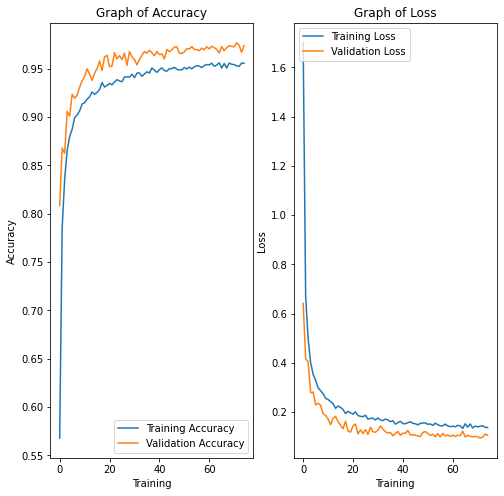

In [ ]:
import numpy as np
import matplotlib.pylab as plt


accurate = history.history['accuracy']
value_accurate = history.history['val_accuracy']

loss = history.history['loss']
value_loss = history.history['val_loss']

iterations_len = range(iterations)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(iterations_len, accurate, label='Training Accuracy')
plt.plot(iterations_len, value_accurate, label='Validation Accuracy')
plt.title("Graph of Accuracy")
plt.legend(loc='lower right')
plt.xlabel("Training")
plt.ylabel("Accuracy")


plt.subplot(1, 2, 2)
plt.plot(iterations_len, loss, label='Training Loss')
plt.plot(iterations_len, value_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Graph of Loss')
plt.xlabel("Training")
plt.ylabel("Loss")

plt.show()

In [ ]:
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (INPUT_SHAPE[0], INPUT_SHAPE[1]) )
    img = img /255
    
    return img

def predictModelFromDisk(image):
    loadedModel = tf.keras.models.load_model("/content/drive/MyDrive/models/efficientNet_50epochs", custom_objects={'KerasLayer':hub.KerasLayer})
    probabilities = loadedModel.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {reversed_labels[class_idx]: probabilities[class_idx]}

def predictImage(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {reversed_labels[class_idx]: probabilities[class_idx]}

Expected class: Corn___Cercospora_leaf_spot Gray_leaf_spot
Predicted class: Corn___Common_rust, confidence: 0.881775


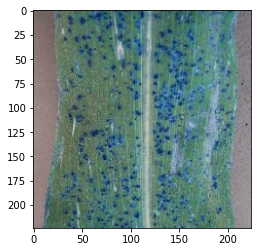

Expected class: Tomato___Target_Spot
Predicted class: Tomato___Target_Spot, confidence: 0.999213


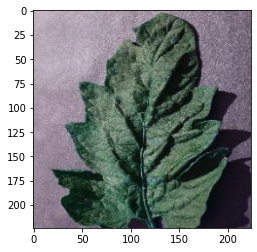

Expected class: Corn___Northern_Leaf_Blight
Predicted class: Corn___healthy, confidence: 0.999161


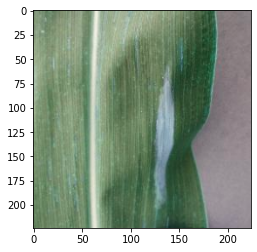

Expected class: Tomato___Late_blight
Predicted class: Tomato___Late_blight, confidence: 1.000000


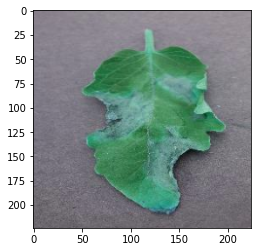

Expected class: Apple___healthy
Predicted class: Apple___healthy, confidence: 1.000000


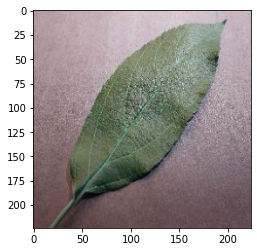

Expected class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 1.000000


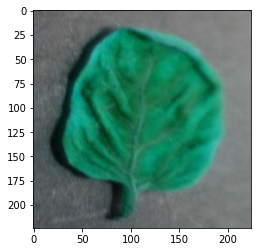

Expected class: Squash___Powdery_mildew
Predicted class: Squash___Powdery_mildew, confidence: 0.559929


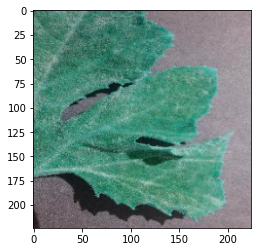

Expected class: Tomato___Late_blight
Predicted class: Tomato___Late_blight, confidence: 1.000000


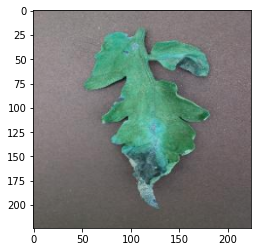

Expected class: Apple___healthy
Predicted class: Apple___healthy, confidence: 0.999728


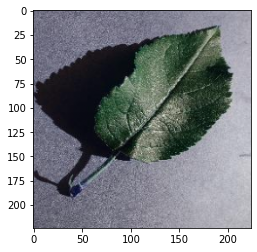

Expected class: Corn___healthy
Predicted class: Corn___healthy, confidence: 1.000000


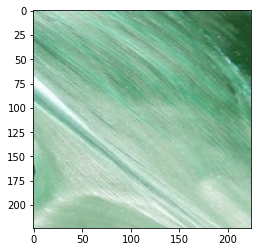

In [ ]:
import random
for id, fileName in enumerate(random.sample(validation_generator.filenames, 10)):
    print("Expected class: %s" % (os.path.split(fileName)[0]))
    ImgPath = os.path.join(path_data_images, fileName)
    img = load_image(ImgPath)
    prediction = predictImage(img)
    print("Predicted class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img) 
    plt.show()

In [ ]:
import time
t = time.time()

export_path = "/content/drive/MyDrive/models/{}".format(int(t))
if not os.path.exists(export_path):
    os.mkdir(export_path)

model.save(export_path)
export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/1614683264/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/1614683264/assets


'/content/drive/MyDrive/models/1614683264'

In [ ]:
# reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# convert the model to TFLite
tflite_dir = os.path.join(export_path,"tflite_model")
if not os.path.exists(tflite_dir):
    os.mkdir(tflite_dir)

tfliteModel = os.path.join(tflite_dir, "plant_disease_model.tflite")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converted_tflite_model = converter.convert()
open(tfliteModel, "wb").write(converted_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7i_ct2hd/assets


INFO:tensorflow:Assets written to: /tmp/tmp7i_ct2hd/assets


18794692